In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import itertools
import os
from xgboost import XGBClassifier
from aux import get_x_data, makeSubmission, plot_precision_and_recall, plot_confusion_matrix, runRandomForests
%matplotlib inline

In [2]:
_PATH_DATASET = '/home/diego/Cursos/FIUBA/git/fiuba-trocafone-tp2-final-set/' # No borrar esto, por compatibilidad para correrlo con datasets en otros directorios

In [14]:
def runXGBoost(X_train, y_train, X_test, y_test, max_depth = 5, learning_rate = 0.1, n_estimators = 100,
              n_jobs = 2, min_child_weight=1):  #, criterion = 'gini', min_samples_split=4):
    # Creo el objeto
    xgb = XGBClassifier(n_estimators = n_estimators,
                        max_depth = max_depth, learning_rate = learning_rate,
                        random_state = 123, n_jobs = n_jobs,objective= 'binary:logistic',
                        gamma=0, subsample=0.8, colsample_bytree=0.8, min_child_weight=min_child_weight,
                        scale_pos_weight=1)
    # Ajusto
    xgb.fit(X_train, y_train)

    # Predigo
    Y_prediction = xgb.predict(X_test)

    # Calculate the absolute errors
    errors = abs(Y_prediction - y_test)

    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    
    #random_forest.score(X_test, Y_prediction)
    acc_xgb = round(xgb.score(X_test, Y_prediction) * 100, 2)
    print(round(acc_xgb,2,), "%")
    return xgb


## Cargo los features

In [15]:
# Cargo los features para entrenamiento
new_vector_features = pd.read_csv(_PATH_DATASET + 'out_features_processed_train.csv')
new_vector_features = new_vector_features.set_index('person')

# Cargo los features para predicción
new_vector_features_to_predict = pd.read_csv(_PATH_DATASET + 'out_features_processed_to_predict.csv')
new_vector_features_to_predict = new_vector_features_to_predict.set_index('person')

to_submit = pd.read_csv(_PATH_DATASET + 'trocafone_kaggle_submit_sample_all_0.csv')

In [16]:
# Muy importante!!! Igual lo estoy haciendo en la predicción
new_vector_features_to_predict = new_vector_features_to_predict.reindex(to_submit.person)

> # Separación de test de entrenamiento y pruebas

In [17]:
cols = {'label':True, 'first_inter_to_june': True} # Elimino los false
# Borro los menos significativos
#cols = {
#    'Computer': False, 'Smartphone': False, 'Tablet': False, 'Unknown': False}


In [18]:
x_data, y_labels = get_x_data(new_vector_features, cols)
x_features_to_predict, y_labels_to_predict = get_x_data(new_vector_features_to_predict, cols)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data,y_labels,test_size=0.1,random_state=101)

In [19]:
new_vector_features.head()

,label,timeDelta,last_inter_to_june,first_inter_to_june,interactions,isNotWeekend,isWeekend,isFortnite,isNotFortnite,month1,...,channel_Social,channel_Unknown,device_type_Computer,device_type_Smartphone,device_type_Tablet,device_type_Unknown,perc_computer,perc_tablet,perc_smartphone,perc_unknown
person,,,,,,,,,,,,,,,,,,,,,
0566e9c1,0,772618.0,26916.0,799534.0,68,5,63,68,0,0,...,0,0,0,17,0,0,0.0,0.0,1.0,0.0
6ec7ee77,0,0.0,336876.0,336876.0,2,0,2,2,0,0,...,0,0,0,1,0,0,0.0,0.0,1.0,0.0
abe7a2fb,0,9335392.0,174046.0,9509438.0,96,32,64,32,64,0,...,2,0,0,22,0,0,0.0,0.0,1.0,0.0
34728364,0,742549.0,388950.0,1131499.0,37,4,33,37,0,0,...,0,0,0,4,0,0,0.0,0.0,1.0,0.0
87ed62de,0,1409.0,1123199.0,1124608.0,17,1,16,17,0,0,...,0,0,1,0,0,0,1.0,0.0,0.0,0.0


> # Hago distintas pruebas

In [20]:
# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

## XGBoost


In [ ]:
from sklearn.grid_search import GridSearchCV   #Perforing grid search
param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=200, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=3, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [22]:
# XGBoost
n_estimators = 140
xgb = runXGBoost(X_train, y_train, X_test, y_test, n_estimators = n_estimators, max_depth=3, min_child_weight = 5)#, criterion='entropy')
y_prediction = xgb.predict(X_test)

Mean Absolute Error: 0.06 degrees.
100.0 %


In [48]:
for i in range(2,5,2):
    print (i)

2
4


In [51]:
# Random Forest
n_estimators = 500
xgb = runXGBoost(X_train, y_train, X_test, y_test, n_estimators = n_estimators)#, criterion='entropy')
y_prediction = xgb.predict(X_test)

Mean Absolute Error: 0.06 degrees.
100.0 %


In [52]:
# predictions = cross_val_predict(random_forest, X_test, y_test, cv=3)
# cnf_matrix = confusion_matrix(y_test, predictions)
# class_names = ['0', '1']
# #plt.figure(figsize=(14, 7))
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

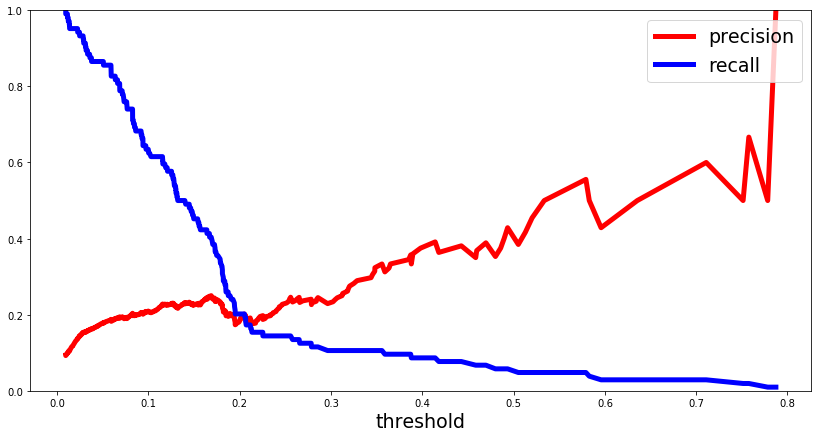

In [23]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores_orig = xgb.predict_proba(X_test)
y_scores = y_scores_orig[:,1]
#y_scores = (y_scores_orig [:,1] >= threshold1).astype('int')
#Si no hay ningún 1 da Warning y no se plotea nada
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)

In [24]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(xgb.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

,importance
feature,
june_to_last_checkout,0.125
june_to_last_search engine hit,0.052
cond_mean,0.035
june_to_last_brand listing,0.033
last_inter_to_june,0.032
first_inter_to_june,0.030
storage_mean,0.028
june_to_last_conversion,0.028
conversion,0.028


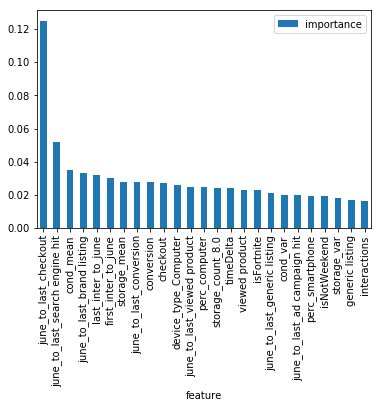

In [25]:
#plt.figure()
plt.figure(figsize=(14, 7))
importances[:25].plot.bar()
plt.show()

In [26]:
y_test_pred = xgb.predict_proba(X_test)

In [27]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_test_pred[:,1])

0.8713693814346698

In [34]:
# RoC AuC, es la que puntúa kaggle
thres = 0.033
roc_auc_score(y_test, (y_test_pred[:, 1]>thres).astype(int))

0.8119140788482464

In [36]:
# Calculo el score medio
xgb.score(X_test, y_test)

0.94490216271884653

In [37]:
sum(y_train) + sum(y_test)

980

In [38]:
sum(y_test)

104

In [39]:
sum(y_test_pred[:,1]>thres)

590

In [41]:
y_pred_to_predict = xgb.predict_proba(x_features_to_predict)
ts = makeSubmission(y_pred_to_predict, to_submit, thres)

In [42]:
ts.to_csv('estima40porcientoXGB.csv')

In [31]:
fin

NameError: name 'fin' is not defined

### Vuelvo a realizar RandomForests con menos features

In [ ]:
y_scores_predicted = random_forest.predict_proba()

In [ ]:
y_labels_to_predict.head()

In [42]:
# Borro los menos significativos
cols = {
    'month4': False, '1.0': False, 'month3': False, 'conversion': False, 'staticpage': False, 'month1': False,
    'month2': False, '5.0': False, 'lead': False}

In [43]:
x_data, y_labels = get_x_data(new_vector_features, cols)
x_features_to_predict, y_labels_to_predict = get_x_data(new_vector_features_to_predict, cols)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data,y_labels,test_size=0.3,random_state=101)

In [44]:
x_data.columns

Index(['timeDelta', 'last_inter_to_june', 'first_inter_to_june',
       'interactions', 'isNotWeekend', 'isWeekend', 'isFortnite',
       'isNotFortnite', 'month5', 'ad campaign hit', 'brand listing',
       'checkout', 'generic listing', 'search engine hit', 'searched products',
       'viewed product', 'visited site', '2.0', '3.0', '4.0', 'cond_var',
       'cond_mean'],
      dtype='object')

In [46]:
# Vuelvo a crear el objeto random_forest
# Random Forest
n_estimators = 50
random_forest = runRandomForests(X_train, y_train, X_test, y_test, n_estimators = n_estimators)
y_prediction = random_forest.predict(X_test)

Mean Absolute Error: 0.05 degrees.
100.0 %


Confusion matrix, without normalization
[[5518   11]
 [ 294    2]]


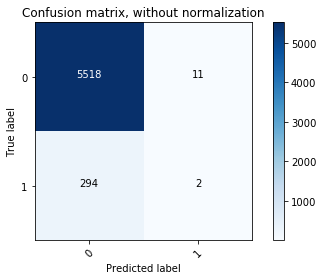

In [47]:
predictions = cross_val_predict(random_forest, X_test, y_test, cv=3)
cnf_matrix = confusion_matrix(y_test, predictions)
class_names = ['0', '1']
# plt.figure(figsize=(14, 7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

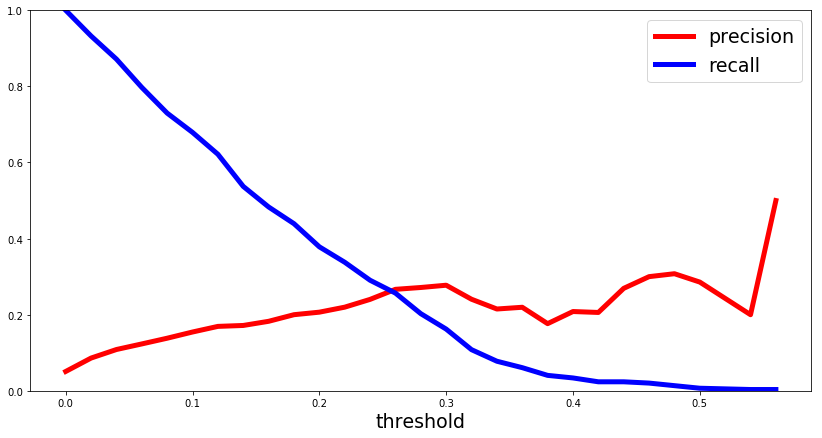

In [48]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores_orig = random_forest.predict_proba(X_test)
y_scores = y_scores_orig[:,1]
#y_scores = (y_scores_orig [:,1] >= threshold1).astype('int')
#Si no hay ningún 1 da Warning y no se plotea nada
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)

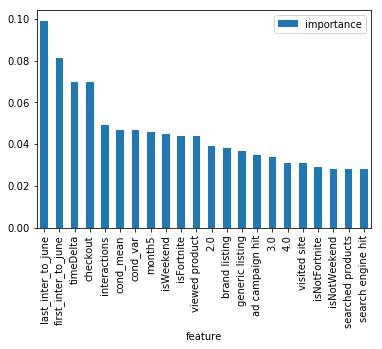

In [49]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
#plt.figure()
importances.plot.bar()
plt.show()

In [50]:
# Vuelvo a crear el objeto random_forest
# Random Forest
n_estimators = 150
random_forest = runRandomForests(X_train, y_train, X_test, y_test, n_estimators = n_estimators)
y_prediction = random_forest.predict(X_test)

Mean Absolute Error: 0.05 degrees.
100.0 %


Confusion matrix, without normalization
[[5519   10]
 [ 295    1]]


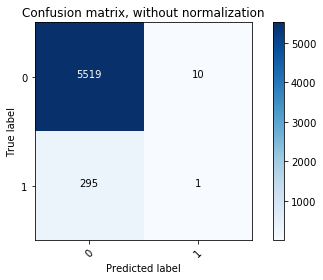

In [51]:
predictions = cross_val_predict(random_forest, X_test, y_test, cv=3)
cnf_matrix = confusion_matrix(y_test, predictions)
class_names = ['0', '1']
# plt.figure(figsize=(14, 7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

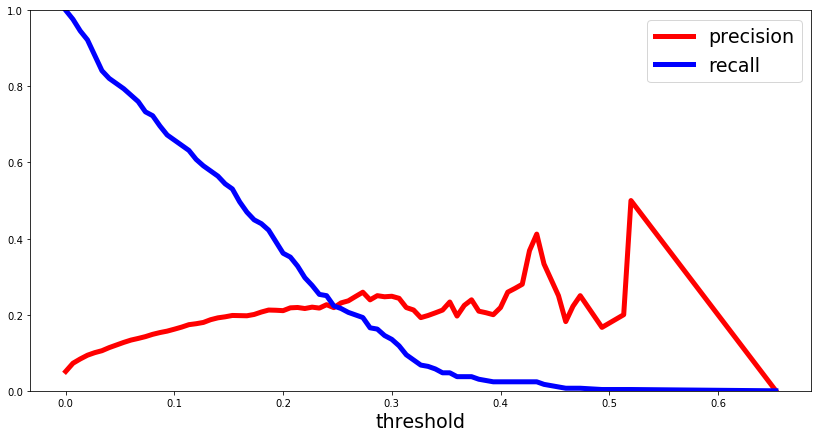

In [52]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores_orig = random_forest.predict_proba(X_test)
y_scores = y_scores_orig[:,1]
#y_scores = (y_scores_orig [:,1] >= threshold1).astype('int')
#Si no hay ningún 1 da Warning y no se plotea nada
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)

In [53]:
# Vuelvo a crear el objeto random_forest
# Random Forest
n_estimators = 50
random_forest = runRandomForests(X_train, y_train, X_test, y_test, n_estimators = n_estimators)
y_prediction = random_forest.predict(X_test)

Mean Absolute Error: 0.05 degrees.
100.0 %


Confusion matrix, without normalization
[[5519   10]
 [ 291    5]]


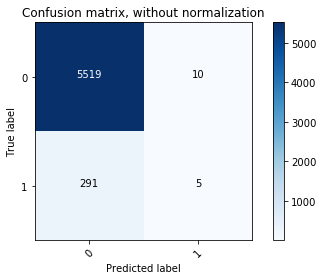

In [54]:
predictions = cross_val_predict(random_forest, X_test, y_test, cv=3)
cnf_matrix = confusion_matrix(y_test, predictions)
class_names = ['0', '1']
# plt.figure(figsize=(14, 7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

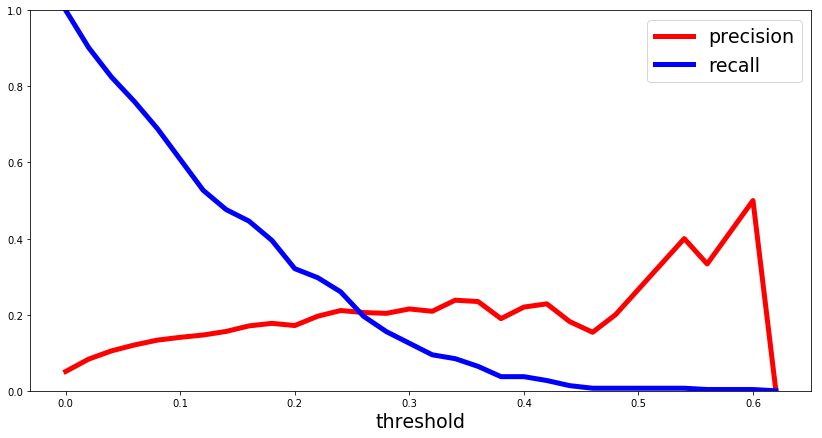

In [55]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores_orig = random_forest.predict_proba(X_test)
y_scores = y_scores_orig[:,1]
#y_scores = (y_scores_orig [:,1] >= threshold1).astype('int')
#Si no hay ningún 1 da Warning y no se plotea nada
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)

## Pruebo con PCA

In [155]:
from sklearn.decomposition import PCA

In [156]:
cols = {}
x_data, y_labels = get_x_data(new_vector_features, cols)
x_features_to_predict, y_labels_to_predict = get_x_data(new_vector_features_to_predict, cols)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data,y_labels,test_size=0.3,random_state=101)

In [157]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test) 

In [158]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)

In [159]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=50, random_state=0)  
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)  

Confusion matrix, without normalization
[[5515   14]
 [ 289    7]]


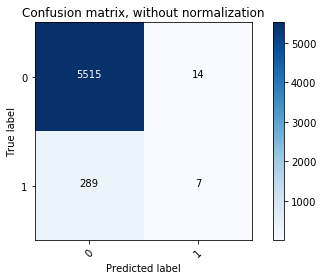

In [160]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)  
#print(cm)  
#print('Accuracy' + accuracy_score(y_test, y_pred))
class_names = ['0', '1']
# plt.figure(figsize=(14, 7))
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')

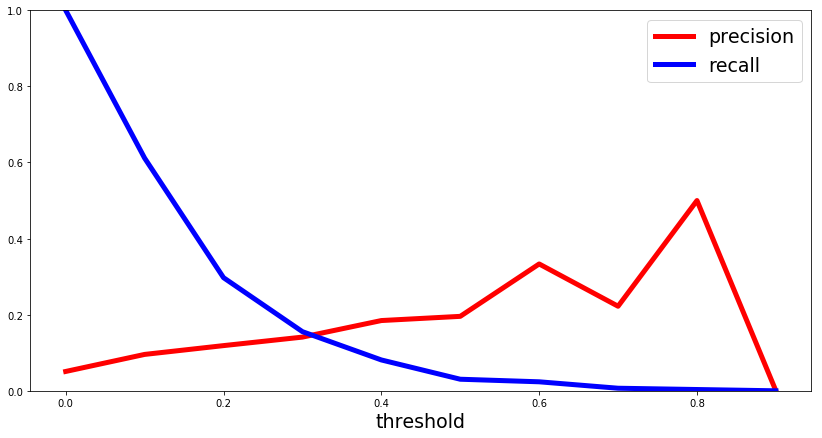

In [161]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores_orig = classifier.predict_proba(X_test)
y_scores = y_scores_orig[:,1]
#y_scores = (y_scores_orig [:,1] >= threshold1).astype('int')
#Si no hay ningún 1 da Warning y no se plotea nada
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)

In [56]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_test, Y_pred) * 100, 2)
print(round(acc_log,2,), "%")



100.0 %


In [57]:
predictions = cross_val_predict(logreg, X_test, y_test, cv=3)
cnf_matrix = confusion_matrix(y_test, predictions)

Confusion matrix, without normalization
[[5529    0]
 [ 296    0]]


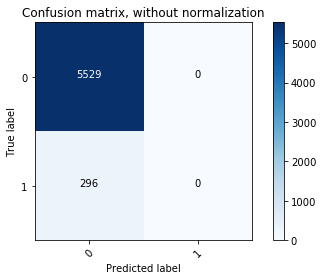

In [58]:
class_names = ['0', '1']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')